In [1]:
import torch
from torch.distributions import constraints
from torch.nn import Parameter
import numpy as np
import pyro 
import pyro.contrib.gp as gp
import pyro.distributions as dist
from pyro.contrib.gp.models.model import GPModel
from pyro.contrib.gp.util import conditional
from pyro.distributions.util import eye_like
from pyro.nn.module import PyroParam, pyro_method
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal


class VariationalGP(GPModel):
    r"""
    Variational Gaussian Process model.
    This model deals with both Gaussian and non-Gaussian likelihoods. Given inputs\
    :math:`X` and their noisy observations 
    :math:`y`, the model takes the form
    .. math::
        f &\sim \mathcal{GP}(0, k(X, X)),\\
        y & \sim p(y) = p(y \mid f) p(f),
    where 
    :math:`p(y \mid f)` is the likelihood.
    We will use a variational approach in this model by approximating 
    :math:`q(f)` to the posterior :math:`p(f\mid y)`. Precisely, :math:`q(f)` will be a multivariate
    normal distribution with two parameters ``f_loc`` and ``f_scale_tril``, which will
    be learned during a variational inference process.

    .. note:: This model can be seen as a special version of
        :class:`.SparseVariationalGP` model with :math:`X_u = X`.
    .. note:: This model has :math:`\mathcal{O}(N^3)` complexity for training,
        :math:`\mathcal{O}(N^3)` complexity for testing. Here, :math:`N` is the number
        of train inputs. 
        Size of variational parameters is :math:`\mathcal{O}(N^2)`.

    :param torch.Tensor X: A input data for training. Its first dimension is the number
        of data points.

    :param torch.Tensor y: An output data for training. Its last dimension is the
        number of data points.

    :param ~pyro.contrib.gp.kernels.kernel.Kernel kernel: A Pyro kernel object, which
        is the covariance function :math:`k`.

    :param ~pyro.contrib.gp.likelihoods.likelihood Likelihood likelihood: A likelihood
        object.

    :param callable mean_function: An optional mean function :math:`m` of this Gaussian
        process. By default, we use zero mean.

    :param torch.Size latent_shape: Shape for latent processes (`batch_shape` of
        :math:`q(f)`). By default, it equals to output batch shape ``y.shape[:-1]``.
        For the multi-class classification problems, ``latent_shape[-1]`` should
        corresponse to the number of classes.

    :param bool whiten: A flag to tell if variational parameters ``f_loc`` and
        ``f_scale_tril`` are transformed by the inverse of ``Lff``, where ``Lff`` is
        the lower triangular decomposition of :math:`kernel(X, X)`. Enable this flag
        will help optimization.
        
    :param float jitter: A small positive term which is added into the diagonal part of
        a covariance matrix to help stablize its Cholesky decomposition.
    """
    
    def __init__(self, X, y, kernel, likelihood, mean_function=None,
                 latent_shape=None, whiten=False, jitter=1e-6):
        super().__init__(X, y, kernel, mean_function, jitter)

        #Split up X
        X_nn_1 = X[:,0:5]
        X_nn_2 = X[:,7:]
        self.X_GP = torch.tensor(np.hstack([X_nn_1,X_nn_2]))
        self.X_linear = torch.tensor(X[:,5:7])

        #___________________________GP part____________________________________________
        #Define likelihood
        self.likelihood = likelihood

        # define batch shape and latent space shape
        y_batch_shape = self.y.shape[:-1] if self.y is not None else torch.Size([])
        self.latent_shape = latent_shape if latent_shape is not None else y_batch_shape

        # number of features
        N = self.X_GP.size(0) # N = shape(1025)
        
        #initialize mean vector to be learned
        f_loc = self.X_GP.new_zeros(self.latent_shape + (N,))
        #print(type(f_loc))
        #set mean vector as parameter
        self.f_loc = Parameter(f_loc)
        #print(self.f_loc)
        #initialize identity matrix of size: (1025, 1025)
        identity = eye_like(self.X_GP, N)

        #initialize var vector to be learned 
        f_scale_tril = identity.repeat(self.latent_shape + (1, 1))

        # set var param as parameter
        self.f_scale_tril = PyroParam(f_scale_tril, constraints.lower_cholesky)
        #print('')
        #print(self.f_scale_tril)

        # initialize stuff??
        self.whiten = whiten
        self._sample_latent = True

        #___________________________Lin part____________________________________________
        #set mean vector as parameter
        #
        f_bin = self.X_linear.new_zeros(self.latent_shape + (2,))
        self.f_bin = Parameter(f_bin)

        self.beta_vals_1 = []
        self.beta_vals_2 = []





    @pyro_method
    def model(self):
        self.set_mode("model")


        N = self.X_GP.size(0)
        Kff = self.kernel(self.X_GP).contiguous()
        Kff.view(-1)[::N + 1] += self.jitter  # add jitter to the diagonal
        Lff = Kff.cholesky()
        #print('model is used for training')
        #initialize 
        zero_loc = self.X_GP.new_zeros(self.f_loc.shape)
        
        if self.whiten:

            identity = eye_like(self.X_GP, N) #

            pyro.sample(self._pyro_get_fullname("f"),
                        dist.MultivariateNormal(zero_loc, scale_tril=identity)
                            .to_event(zero_loc.dim() - 1))
            
            f_scale_tril = Lff.matmul(self.f_scale_tril)

            f_loc = Lff.matmul(self.f_loc.unsqueeze(-1)).squeeze(-1)
        else:
            pyro.sample(self._pyro_get_fullname("f"),
                        dist.MultivariateNormal(zero_loc, scale_tril=Lff)
                            .to_event(zero_loc.dim() - 1))
            f_scale_tril = self.f_scale_tril
            f_loc = self.f_loc

        f_loc = f_loc + self.mean_function(self.X_GP)
        f_var = f_scale_tril.pow(2).sum(dim=-1)

        zero_loc_bin = self.X_linear.new_zeros(self.f_bin.shape)
        pyro.sample(self._pyro_get_fullname("beta"), dist.Normal(zero_loc_bin, 0.1*torch.ones(2)).to_event())
        f_bin = self.f_bin

        lin_out = self.X_linear@f_bin
        #print('1 ', f_bin[0].detach().numpy())
        #print('2 ', f_bin[1].detach().numpy())
        #print(' ')
        self.beta_vals_1.append(f_bin[0].detach().numpy())
        self.beta_vals_2.append(f_bin[1].detach().numpy())
        

        if self.y is None:
            return f_loc, f_var
        else:
            #print(f_loc.sum())
            res = self.likelihood(f_loc+lin_out, f_var, self.y)
            #print(res)
            return res

    @pyro_method
    def guide(self):

        self.set_mode("guide")

        self._load_pyro_samples()

        #print('guide is used for training')
        
        pyro.sample(self._pyro_get_fullname("f"),
                    dist.MultivariateNormal(self.f_loc, scale_tril=self.f_scale_tril)
                        .to_event(self.f_loc.dim()-1))
        
        pyro.sample(self._pyro_get_fullname("beta"), dist.Normal(self.f_bin, 0.1*torch.ones(2)).to_event())

    def forward(self, Xnew, full_cov=False):
        X_nn_1 = Xnew[:,0:5]
        X_nn_2 = Xnew[:,7:]
        X_GP = torch.tensor(np.hstack([X_nn_1,X_nn_2]))
        X_linear = Xnew[:,5:7]
        
        r"""
        Computes the mean and covariance matrix (or variance) of Gaussian Process
        posterior on a test input data :math:`X_{new}`:
        .. math:: p(f^* \mid X_{new}, X, y, k, f_{loc}, f_{scale\_tril})
            = \mathcal{N}(loc, cov).

        .. note:: Variational parameters ``f_loc``, ``f_scale_tril``, together with
            kernel's parameters have been learned from a training procedure (MCMC or
            SVI).
            
        :param torch.Tensor Xnew: A input data for testing. Note that
            ``Xnew.shape[1:]`` must be the same as ``self.X.shape[1:]``.

        :param bool full_cov: A flag to decide if we want to predict full covariance
            matrix or just variance.
            
        :returns: loc and covariance matrix (or variance) of :math:`p(f^*(X_{new}))`
        :rtype: tuple(torch.Tensor, torch.Tensor)
        """
        #beta_lin = pyro.sample("beta", dist.Normal(0, 1))
        
        #self._check_Xnew_shape(X_GP)
        self.set_mode("guide")

        loc, cov = conditional(X_GP, self.X_GP, self.kernel, self.f_loc, self.f_scale_tril,
                               full_cov=full_cov, whiten=self.whiten, jitter=self.jitter)
        #print(self.f_bin)
        #print(X_linear.shape)
        linear_out = X_linear@self.f_bin

        return loc + self.mean_function(X_GP), cov, linear_out
    


    

In [2]:
import numpy as np
from scipy.stats import norm, multivariate_normal
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib options
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

In [3]:
# Make data
# X, y = make_moons(n_samples=50, shuffle=True, noise=0.1, random_state=1)
from func import get_data

# Read data.
X_train,y_train,X_test,y_test,age,names = get_data(False,True)


# Prepare data for Pyro model
n_cat = int(y_train.max())

#print('n_ind', n_ind)
X_train_tensor = torch.tensor(X_train.astype('float')).float()
#X_train_tensor = torch.tensor(X_train, dtype=torch.float)
y_train_tensor = torch.tensor(y_train).float()
X_test_tensor = torch.tensor(X_test.astype('float')).float()
#X_test_tensor = torch.tensor(X_test, dtype=torch.float)
y_test_tensor = torch.tensor(y_test).float()
#print(y_train_tensor)

p,n = X_train.shape

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

print(X_train_tensor.shape)
print(y_train_tensor.shape)




(1025, 30)
(1025,)
(303, 30)
(303,)
torch.Size([1025, 30])
torch.Size([1025])


/var/folders/rl/2d6x2yy927z8k4n7s2v1ng3m0000gn/T/ipykernel_2454/1984395212.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_linear = torch.tensor(X[:,5:7])
/var/folders/rl/2d6x2yy927z8k4n7s2v1ng3m0000gn/T/ipykernel_2454/1984395212.py:130: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH().
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_9d63z49rj_/croot/pytorch_1681837279022/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:1626.)
  Lff = Kff.cholesky(

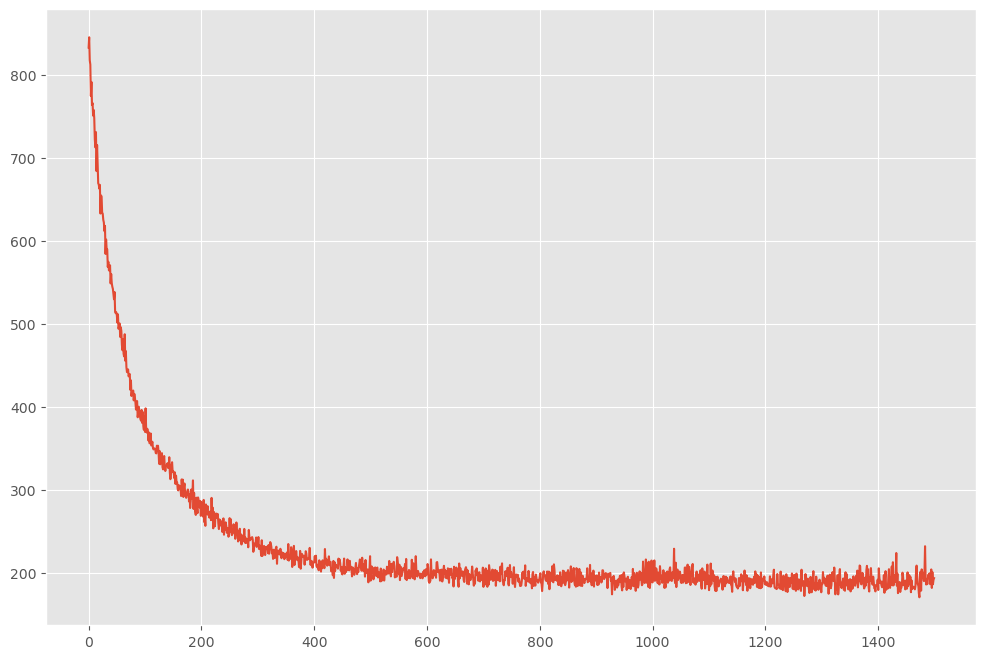

In [4]:

# initialize the kernel, likelihood, and model
pyro.clear_param_store()
#kernel = gp.kernels.RBF(input_dim=13, lengthscale=torch.ones(13)) # 96.37% accuracy
kernel = gp.kernels.Matern32(input_dim=n-2, lengthscale=torch.ones(n-2)) # 99.01% accuracy
likelihood = gp.likelihoods.Binary()

# turn on "whiten" flag for more stable optimization
#vsgp = VariationalGP(X_train_tensor.reshape(-1, 13), y_train_tensor.reshape(-1), kernel, likelihood=likelihood, whiten=True, jitter=1e-6)

model = VariationalGP(
    X_train_tensor,
    y_train_tensor,
    kernel,
    likelihood=likelihood,
    whiten=True,
    jitter=1e-03,
    latent_shape=torch.Size([]),
)

# instead of defining our own training loop, we will
# use the built-in support provided by the GP module
num_steps = 1500
#losses = gp.util.train(vsgp, num_steps=num_steps)
losses = gp.util.train(model, num_steps=num_steps)
#plt.plot(losses);
#jitter = 1e-6
#Lff = torch.cholesky(Kff + jitter * torch.eye(Kff.shape[0]))¨

plt.plot(losses)

In [5]:


print(model.f_bin)

#output, cov, beta_lin = model.forward(X_test_tensor)
#print("Beta:", beta_lin.item())  # Printing the value of beta_lin

Parameter containing:
tensor([ 0.0181, -0.0221], requires_grad=True)


In [6]:
#mean, var = model(X_train_tensor)
#y_hat = model.likelihood(mean, var)

#print(f"Accuracy: {(y_hat==y_train_tensor).sum()*100/(len(y_train_tensor)) :0.2f}%")
acc = []
for i in range(1000):
    mean, var, linout = model(X_test_tensor)

    #throw it through model likelihood to get prediction
    y_hat = model.likelihood(mean+linout, var)
    #print(y_hat)
    acc.append((y_hat==y_test_tensor).sum()*100/(len(y_test_tensor)))


print(f"Accuracy: {np.mean(acc) :0.2f}%")

Accuracy: 97.81%


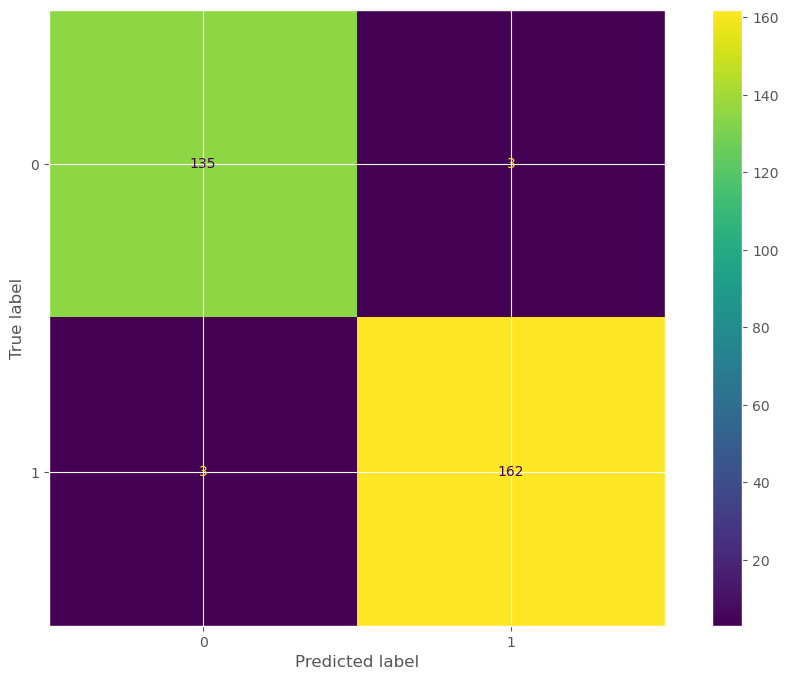

In [7]:
#cm = confusion_matrix(y_train_tensor, y_hat, labels=[0, 1])
#ConfusionMatrixDisplay(cm).plot()

cm = confusion_matrix(y_test_tensor, y_hat, labels=[0, 1])
ConfusionMatrixDisplay(cm).plot()

In [86]:
# Make predictions for test set
from pyro.infer import Predictive
predictive = Predictive(model, num_samples=1000,
                        return_sites=("obs", "_RETURN"))
samples = predictive(X_test_tensor)

samples = samples['obs'].detach().squeeze()
y_hat = np.round(samples.mean(axis=0).numpy())

mae = np.mean(np.abs(y_test - y_hat))
print("MAE:", mae)
print("Accuracy:", 1.0*np.sum((y_hat) == y_test) / len(y_test))

Parameter containing:
tensor([ 0.0289, -0.0298], requires_grad=True)
Parameter containing:
tensor([ 0.0289, -0.0298], requires_grad=True)
Parameter containing:
tensor([ 0.0289, -0.0298], requires_grad=True)
Parameter containing:
tensor([ 0.0289, -0.0298], requires_grad=True)
Parameter containing:
tensor([ 0.0289, -0.0298], requires_grad=True)
Parameter containing:
tensor([ 0.0289, -0.0298], requires_grad=True)
Parameter containing:
tensor([ 0.0289, -0.0298], requires_grad=True)
Parameter containing:
tensor([ 0.0289, -0.0298], requires_grad=True)
Parameter containing:
tensor([ 0.0289, -0.0298], requires_grad=True)
Parameter containing:
tensor([ 0.0289, -0.0298], requires_grad=True)
Parameter containing:
tensor([ 0.0289, -0.0298], requires_grad=True)
Parameter containing:
tensor([ 0.0289, -0.0298], requires_grad=True)
Parameter containing:
tensor([ 0.0289, -0.0298], requires_grad=True)
Parameter containing:
tensor([ 0.0289, -0.0298], requires_grad=True)
Parameter containing:
tensor([ 0.0

TypeError: expected Tensor as element 0 in argument 0, but got tuple

In [23]:
# Prepare test data for Pyro
X_test = torch.tensor(X_test).float()

guide = AutoDiagonalNormal(model)

In [25]:
from pyro.infer import Predictive

# Get posterior samples for beta
predictive = Predictive(model, guide=guide, num_samples=1000,
                        return_sites=("beta",))
samples = predictive(X_, y_test)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
Trace Shapes:
 Param Sites:
Sample Sites:
Trace Shapes:
 Param Sites:
Sample Sites: